# ML on ESDC using PyTorch 
A DeepESDL example notebook

## Linear Regression for prediction of missing land surface temperature values from air temperature values
This notebook showcases how to implement Machine Learning on the Earth System Data Cube using Pytorch for multidimensional data containing gaps. In the following example those values are replaced with the sample mean in order to enable the application of Machine Learning.

Please, also refer to the DeepESDL documentation and visit the platform's website for further information!

ScaDS.AI, 2023

**This notebook runs needs a python conda environment with pytorch and mlflow installed, please checkout the documentation for help on [changing the environment](https://deepesdl.readthedocs.io/en/v2022.12.1/guide/jupyterlab/). You can follow the MLFlow Experiment run via the bundled MLFlow UI.**

### Import necessary libraries

In [1]:
import os
import torch
import numpy as np
import xarray as xr
import dask.array as da
import torch.nn.functional as F
from global_land_mask import globe
from torch.utils.data import TensorDataset
from xcube.core.store import new_data_store

### Load Data (Earth System Data Cube)
We load the ESDC (*.zarr) from the s3 data store (lazy load). The ESDC consists of three dimensions (longitude, latitude, time). Out of many available cube variables, which are dask arrays, we load two ("land_surface_temperature", "air_temperature_2m"). 

In [2]:
data_store = new_data_store("s3", root="esdl-esdc-v2.1.1", storage_options=dict(anon=True))
dataset    = data_store.open_data("esdc-8d-0.083deg-184x270x270-2.1.1.zarr")
ds         = dataset[["land_surface_temperature", "air_temperature_2m"]]
ds

<xarray.Dataset>
Dimensions:                   (time: 1840, lat: 2160, lon: 4320)
Coordinates:
  * lat                       (lat) float64 89.96 89.88 89.79 ... -89.87 -89.96
  * lon                       (lon) float64 -180.0 -179.9 -179.8 ... 179.9 180.0
  * time                      (time) datetime64[ns] 1979-01-05 ... 2018-12-31
Data variables:
    land_surface_temperature  (time, lat, lon) float32 dask.array<chunksize=(184, 270, 270), meta=np.ndarray>
    air_temperature_2m        (time, lat, lon) float32 dask.array<chunksize=(184, 270, 270), meta=np.ndarray>
Attributes: (12/35)
    Metadata_conventions :     Unidata Dataset Discovery v1.0
    acknowledgment:            The ESDL team acknowledges all data providers! 
    chunking:                  1x2160x4320
    comment:                   none. 
    contributor_name:          Max Planck Institute for Biogeochemistry
    contributor_role:          ESDL Science Lead 
    ...                        ...
    summary:                   This data set contains a data cube of Earth Sy...
    time_coverage_duration:    P40Y
    time_coverage_end:         31.12.2018
    time_coverage_resolution:  P8D
    time_coverage_start:       05.01.1979
    title:                     Earth System Data Cube

### Train/Test Split assignment
Here you can choose between random sampling and block sampling. Based on the use case, the application of ML analyses on remotely sensed data is prone to autocorrelation, especially when the data is split randomly. Block sampling is one strategy to deal with autocorrelation.

In [3]:
from ml4xcube.splits import assign_rand_split, assign_block_split

# random sampling
#xds = assign_rand_split(
#    ds    = xdsm,
#    split = 0.8
#)

# block sampling
xds = assign_block_split(
    ds         = ds,
    block_size = [("time", 10), ("lat", 100), ("lon", 100)],
    split      = 0.8
)
xds

<xarray.Dataset>
Dimensions:                   (time: 1840, lat: 2160, lon: 4320)
Coordinates:
  * lat                       (lat) float64 89.96 89.88 89.79 ... -89.87 -89.96
  * lon                       (lon) float64 -180.0 -179.9 -179.8 ... 179.9 180.0
  * time                      (time) datetime64[ns] 1979-01-05 ... 2018-12-31
Data variables:
    land_surface_temperature  (time, lat, lon) float32 dask.array<chunksize=(184, 270, 270), meta=np.ndarray>
    air_temperature_2m        (time, lat, lon) float32 dask.array<chunksize=(184, 270, 270), meta=np.ndarray>
    split                     (time, lat, lon) float64 dask.array<chunksize=(10, 100, 100), meta=np.ndarray>
Attributes: (12/35)
    Metadata_conventions :     Unidata Dataset Discovery v1.0
    acknowledgment:            The ESDL team acknowledges all data providers! 
    chunking:                  1x2160x4320
    comment:                   none. 
    contributor_name:          Max Planck Institute for Biogeochemistry
    contributor_role:          ESDL Science Lead 
    ...                        ...
    summary:                   This data set contains a data cube of Earth Sy...
    time_coverage_duration:    P40Y
    time_coverage_end:         31.12.2018
    time_coverage_resolution:  P8D
    time_coverage_start:       05.01.1979
    title:                     Earth System Data Cube

### Train-/ and Test Set Creation and Preprocessing

Initialize XrDataset to analyze 10x10 data samples considering spatial relations. A sample is dropped if it containes entirely missing values for at least one ESDC variable (`drop_nan = 'if_all_nan'`). The gaps within the data are replaced utilizing the sample mean (`fill_method = 'sample_mean'`).

In [4]:
from ml4xcube.datasets.xr_dataset import XrDataset

sampler = XrDataset(
    ds            = xds, 
    chunk_indices = [841], 
    sample_size   = [("time", 1), ("lat", 10), ("lon", 10)],
    to_pred       = "land_surface_temperature",
    drop_nan      = 'if_all_nan',
    fill_method   = 'sample_mean'
)

train_data, test_data = sampler.get_datasets()
X_train, y_train      = train_data 
X_test, y_test        = test_data

X_train.shape, y_train.shape, X_test.shape, y_test.shape

set train and test data


((71202, 1, 10, 10),
 (71202, 1, 10, 10),
 (19119, 1, 10, 10),
 (19119, 1, 10, 10))

Flatten all samples

In [5]:
X_train = X_train.reshape(X_train.shape[0], -1)
X_test  = X_test.reshape(X_test.shape[0], -1)
y_train = y_train.reshape(y_train.shape[0], -1)
y_test = y_test.reshape(y_test.shape[0], -1)

X_train.shape, y_train.shape, X_test.shape, y_test.shape

((71202, 100), (71202, 100), (19119, 100), (19119, 100))

#### Prepare Datasets before Training

In [6]:
from ml4xcube.datasets.pytorch import prep_dataloader

train_ds = TensorDataset(torch.tensor(X_train), torch.tensor(y_train))
test_ds  = TensorDataset(torch.tensor(X_test), torch.tensor(y_test))

train_loader, test_loader = prep_dataloader(train_ds, test_ds, batch_size=64, num_workers=5, parallel=False)

### Define model, loss and optimizer

In [7]:
reg_model = torch.nn.Sequential(
    torch.nn.Linear(in_features=100, out_features=64),
    torch.nn.ReLU(),
    torch.nn.Dropout(p=0.01),
    torch.nn.Linear(in_features=64, out_features=32),
    torch.nn.ReLU(),
    torch.nn.Dropout(p=0.01),
    torch.nn.Linear(in_features=32, out_features=32),
    torch.nn.ReLU(),
    torch.nn.Dropout(p=0.01),
    torch.nn.Linear(in_features=32, out_features=32),
    torch.nn.ReLU(),
    torch.nn.Dropout(p=0.01),
    torch.nn.Linear(in_features=32, out_features=64),
    torch.nn.ReLU(),
    torch.nn.Dropout(p=0.01),
    torch.nn.Linear(in_features=64, out_features=100)  # No activation on the final layer for regression
)

loss  = torch.nn.SmoothL1Loss(reduction="mean")

optimizer = torch.optim.SGD(reg_model.parameters(), lr=0.07)

### Train model

Using cpu device
Epoch 1: Average Loss: 4.0402e-01
Epoch 1: Validation Loss: 3.8827e-01
New best model saved with validation loss: 0.38826913001553326
Epoch 2: Average Loss: 4.0399e-01
Epoch 2: Validation Loss: 3.8842e-01
Epoch 3: Average Loss: 4.0399e-01
Epoch 3: Validation Loss: 3.8796e-01
New best model saved with validation loss: 0.3879606644779244
Epoch 4: Average Loss: 4.0397e-01
Epoch 4: Validation Loss: 3.8820e-01
Epoch 5: Average Loss: 4.0391e-01
Epoch 5: Validation Loss: 3.8843e-01
Epoch 6: Average Loss: 4.0395e-01
Epoch 6: Validation Loss: 3.8799e-01
Epoch 7: Average Loss: 4.0398e-01
Epoch 7: Validation Loss: 3.8816e-01
Epoch 8: Average Loss: 4.0388e-01
Epoch 8: Validation Loss: 3.8787e-01
New best model saved with validation loss: 0.3878651076315233
Epoch 9: Average Loss: 4.0394e-01
Epoch 9: Validation Loss: 3.8824e-01
Epoch 10: Average Loss: 4.0399e-01
Epoch 10: Validation Loss: 3.8805e-01
Epoch 11: Average Loss: 4.0400e-01
Epoch 11: Validation Loss: 3.8815e-01
Epoch 12: A

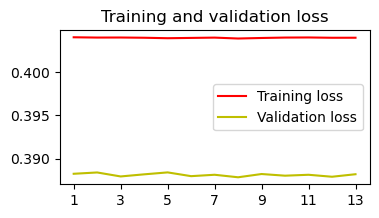

In [8]:
from ml4xcube.training.pytorch import Trainer

# Trainer instance
trainer = Trainer(
    model            = reg_model,
    train_data       = train_loader,
    test_data        = test_loader,
    optimizer        = optimizer,
    model_path       = "./best_model.pth",
    early_stopping   = True,
    loss             = loss,
    patience         = 5,
    epochs           = 20,
    create_loss_plot = True
)

# Start training
reg_model = trainer.train()